In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization import *

In [42]:
def dm_reward(xWs, x_hats, phi, temp=0.02):
    actions = classify(x=x_hats, phi=phi, temp=temp)
    return torch.mean(torch.diag(xWs @ actions))

def phi_regularization(phi):
    return torch.norm(torch.norm(phi, dim=1) - 1)

def gr_phi(Xhats, xWs, u, prev_phi=None, 
           temp=0.02, attempts=5, iters=300): # no additional penalty for finding x?
    n, d = Xhats.shape
    m = u.shape[0]
    if prev_phi is None:
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
    else:
        phi = torch.clone(prev_phi)
        phi.requires_grad_(True)
    best_phi = phi.clone()
    best_reward = dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, temp=temp)
    for _ in range(attempts):
        optimizer = torch.optim.Adam([phi], lr=0.0001)
        for _ in tqdm(range(iters), position=0, leave=True):
            optimizer.zero_grad()
            loss = - dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, temp=temp) # + phi_regularization(phi)
            loss.backward()
            optimizer.step()
            # print(loss)
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_phi = phi.detach()
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
    return best_phi

def ridge_reg(dataset, actions, rewards, lmbda=1.0, alpha=0.01):
    # lambda is regularization param, alpha is param for stdev
    n, d = dataset.shape
    _, m = actions.shape
    assert len(dataset) == n
    assert len(rewards) == n
    sum_r_x = torch.zeros((m, d))
    sum_x_x = torch.zeros(m)
    for t in range(n):
        a = torch.argmax(actions[t]).item()
        sum_r_x[a] += rewards[t] * dataset[t]
        sum_x_x[a] += dataset[t] @ dataset[t]
    phi = (sum_r_x + alpha * torch.sqrt(lmbda + sum_x_x)) / (lmbda + sum_x_x)
    return phi

In [3]:
m = 2
d = 2
n = 1_000
dataset = torch.column_stack([torch.rand((n, d)), torch.ones(n)])
u = torch.tensor([0.15, 0.1])

In [38]:
phi = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
W = torch.tensor([[1., 1/np.sqrt(5)], [0., 2/np.sqrt(5)], [0.2, 0.0]], dtype=torch.float32)

In [40]:
m = 3
phi = torch.tensor([[1, 0, 0.1], [0, 1, 0.1], [0.7, 0.7, 0.]], dtype=torch.float32)
W = phi.T
u = torch.tensor([0.1, 0.1, 0.15])

In [18]:
x_hat = torch.stack([gragent(x, phi, u, attempts=1, iters=500) for x in tqdm(dataset, position=0, leave=True)])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


In [19]:
xW = dataset @ W

In [8]:
# -dm_reward(xW, dataset, phi, b, temp=0.02), -dm_reward(dataset @ W, dataset, phi_hat, b_hat, temp=0.02)

In [8]:
phi_hat = gr_phi(dataset, xW, u, temp=0.02, attempts=6, iters=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 307.69it/s]


In [20]:
phi_hat = gr_phi(x_hat, xW, u, temp=0.02, attempts=6, iters=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 394.15it/s]


In [21]:
# classify(dataset[0], phi_hat, 0.02), phi_hat, phi

In [30]:
lbls = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi, temp=0.02).T]
preds = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi_hat, temp=0.02).T]

In [31]:
# phi_3 = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
# dataset_3 = torch.column_stack([torch.rand((n, d)), torch.ones(n)])
# lbls_3 = [a[0] > a[1] for a in classify(x=dataset_3, phi=phi_3, temp=0.02).T]
# plt.gca().set_aspect('equal')
# plt.scatter(dataset_3[:,0], dataset_3[:,1], c=lbls_3)

In [32]:
# phi_test_1 = [1.0, 0.0]
# phi_test_2 = [0.5, 1.0]
# phi_test_1 /= np.linalg.norm(phi_test_1)
# phi_test_2 /= np.linalg.norm(phi_test_2)

# phi_test = torch.tensor(
#     [phi_test_1, phi_test_2], dtype=torch.float32
# )
# lbls_test = [a[0] > a[1] for a in classify(x=dataset, phi=phi_test, temp=0.02).T]
# plt.gca().set_aspect('equal')
# plt.scatter(dataset[:,0], dataset[:,1], c=lbls_test)

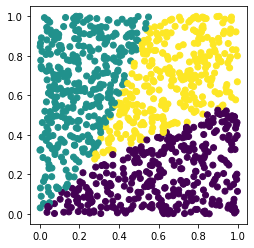

In [33]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=lbls)

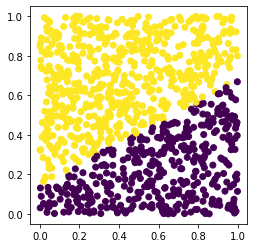

In [34]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=preds)

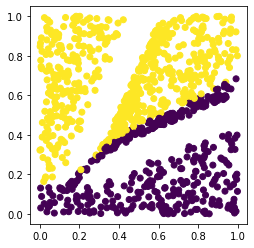

In [35]:
plt.gca().set_aspect('equal')
plt.scatter(x_hat[:,0], x_hat[:,1], c=preds)

In [36]:
phi

tensor([[1.0000, 0.0000, 0.1000],
        [0.0000, 1.0000, 0.1000],
        [0.7000, 0.7000, 0.0000]])

In [37]:
phi_hat

tensor([[0.7669, 0.2829, 0.8949],
        [0.0901, 0.8915, 0.2267],
        [0.3631, 1.0557, 0.7795]])